## ANLY 677 Final Project
### Clare Garberg

# Fine Grained Analysis with ResNet18

### Importing Required Libraries

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import PIL
import torchvision
import numpy as np
import pandas as pd
import tqdm
import cv2
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
import pandas as pd

## Data Preprocessing  
- Downloading and extracting custom datasets  
- Loading custom datasets  
- Calculating the mean and std for normalization on custom datasets  
- Loading transforms to augment and normalize our data  

### **Make sure to drop grayscale images or any other odd images**

In [88]:
root = "/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2"

os.chdir(root)

train_path = "/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/train_data"

test_path = "/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/test_data"

In [89]:
from torchvision.transforms.transforms import CenterCrop


class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')


mean = [0.5683, 0.5578, 0.5178]
std = [0.2378, 0.2437, 0.2670]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(224),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=mean,
          std=std
          )
    ]
)

train = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train, 
    batch_size= 16,
    shuffle=True
)

test = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test, 
    batch_size= 16,
    shuffle=True
)

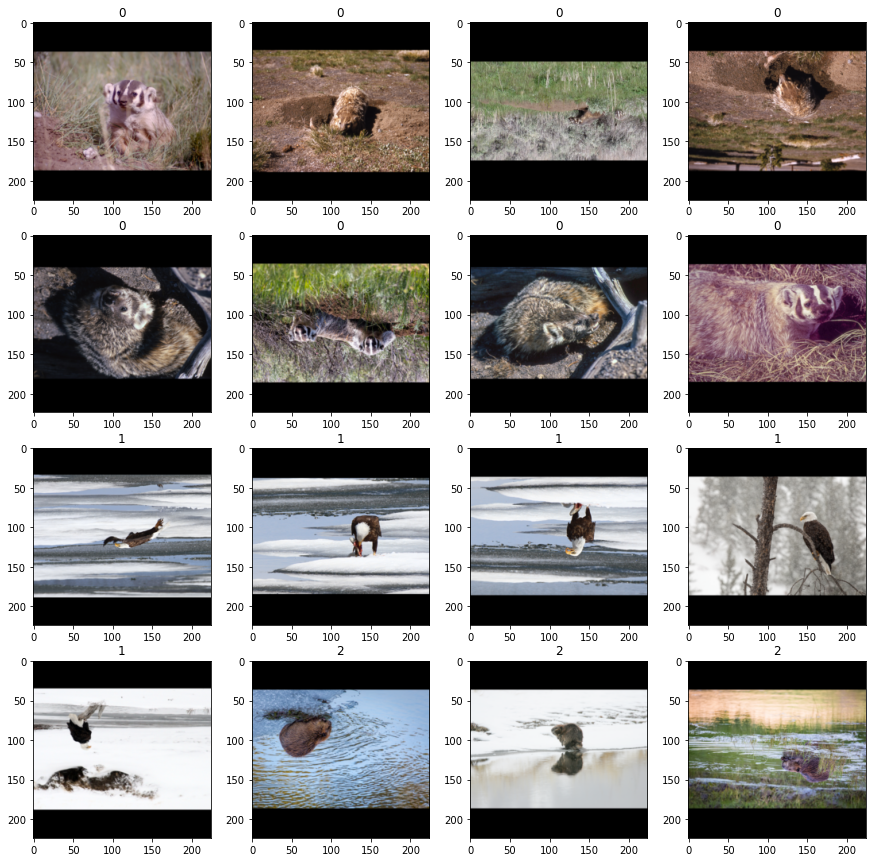

In [90]:
fig, axes = plt.subplots(4,4,figsize= (15,15))

for i in range(16):

  img = train[i][0].numpy().transpose(1, 2, 0)
  img = np.clip((std * img) + mean, 0, 1)
  axes.flat[i].imshow(img)
  axes.flat[i].set_title(str(train[i][1]))

# Follow aspect ratio of either 1:1 or 1.68:1 (8.5, 4.75/5)
#fig.savefig('/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/train_image_transformations_Project.jpg', dpi=300, bbox_inches='tight')  
#fig.savefig('/Users/claregarberg/Documents/Graduate School/Summer 2022/Image Analytics/ANLY677_FinalProject_v2/train_image_transformations_Project.png', dpi=300, bbox_inches='tight')  
plt.show()

### Define Model(ResNet18)
**We will use first 7 layers of ResNet18 model and add 2 custom FC linear layer with batch normalization as shown below**

In [91]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet18
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 15)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

cuda = False    

if torch.cuda.is_available():
  cuda = True

ResNet_18 = Net()

if cuda:
  ResNet_18.cuda()

print(ResNet_18)

Net(
  (top_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

### Optimizer
We will use **Adam** as our optimizer

In [92]:
optimizer = optim.SGD(params = ResNet_18.parameters(),   lr= 1e-3, momentum= 0.9 )
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = nn.CrossEntropyLoss()

### Training Loop

In [93]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

ResNet_18.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data, target) in enumerate(train_loader):
    ResNet_18.train()
    if cuda:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()

    out = ResNet_18(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  test_running_loss = 0
  ResNet_18.eval()

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ResNet_18(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

    LTest = test_running_loss/len(test_loader)

  LTrain = running_loss/len(train_loader)
  accu = 100.*correct/total

  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 30	 Batch Loss: 4.223	  Epoch Loss: 3.212	 Train Acc: 5.814	 Test Loss: 3.
EPOCH 50	 Batch Loss: 0.527	  Epoch Loss: 0.131	 Train Acc: 100.000	 Test Loss: 

## Model training

In [94]:
def save_model(m, p):
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    m.load_state_dict(torch.load(p))

In [95]:
p = "model1_tmp.pth"
save_model(ResNet_18, str(p))
load_model(ResNet_18, str(p))

### Unfreeze the layers

In [96]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [97]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [98]:
unfreeze(ResNet_18, 7)
unfreeze(ResNet_18, 6)
unfreeze(ResNet_18, 5)

### Unfreezing few more layers

In [99]:
load_model(ResNet_18, str(p))
unfreeze(ResNet_18, 4)
unfreeze(ResNet_18, 3)
unfreeze(ResNet_18, 2)

In [100]:
from datetime import datetime
import tqdm as tqdm

EPOCHS = 50  # 50

train_loss = [np.nan]
train_accuracy = [np.nan]
test_loss = [np.nan]

ResNet_18.train()

pbar = tqdm.tqdm(total=EPOCHS, position=0, leave=True)
pbar.set_description("EPOCH 1: Training Loss: NA, ")


for epoch in range(EPOCHS):
  total, correct, running_loss = 0, 0, 0

  for batch_idx, (data, target) in enumerate(train_loader):
    ResNet_18.train()
    if cuda:
      data, target = data.cuda(), target.cuda()
    
    optimizer.zero_grad()

    out = ResNet_18(data)

    loss = criterion(out, target)
    loss.backward()
    optimizer.step()

    current_loss = loss.cpu().data.item()
    running_loss += current_loss

    _, predicted = out.max(1)
    total += target.size(0)
    correct += predicted.eq(target).sum().cpu().item()

    pbar.set_description(f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  test_running_loss = 0
  ResNet_18.eval()

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      if cuda:
        data, target = data.cuda(), target.cuda()

      out = ResNet_18(data)

      loss = criterion(out, target)

      test_running_loss += loss.cpu().data.item()

    LTest = test_running_loss/len(test_loader)

  LTrain = running_loss/len(train_loader)
  accu = 100.*correct/total

  train_accuracy.append(accu)
  train_loss.append(LTrain)
  test_loss.append(LTest)

  pbar.set_description(
      f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")

  pbar.update()

del train_accuracy[0]
del train_loss[0]
del test_loss[0]

EPOCH 50	 Batch Loss: 0.527	  Epoch Loss: 0.131	 Train Acc: 100.000	 Test Loss: 
EPOCH 50	 Batch Loss: 0.017	  Epoch Loss: 0.011	 Train Acc: 100.000	 Test Loss: 

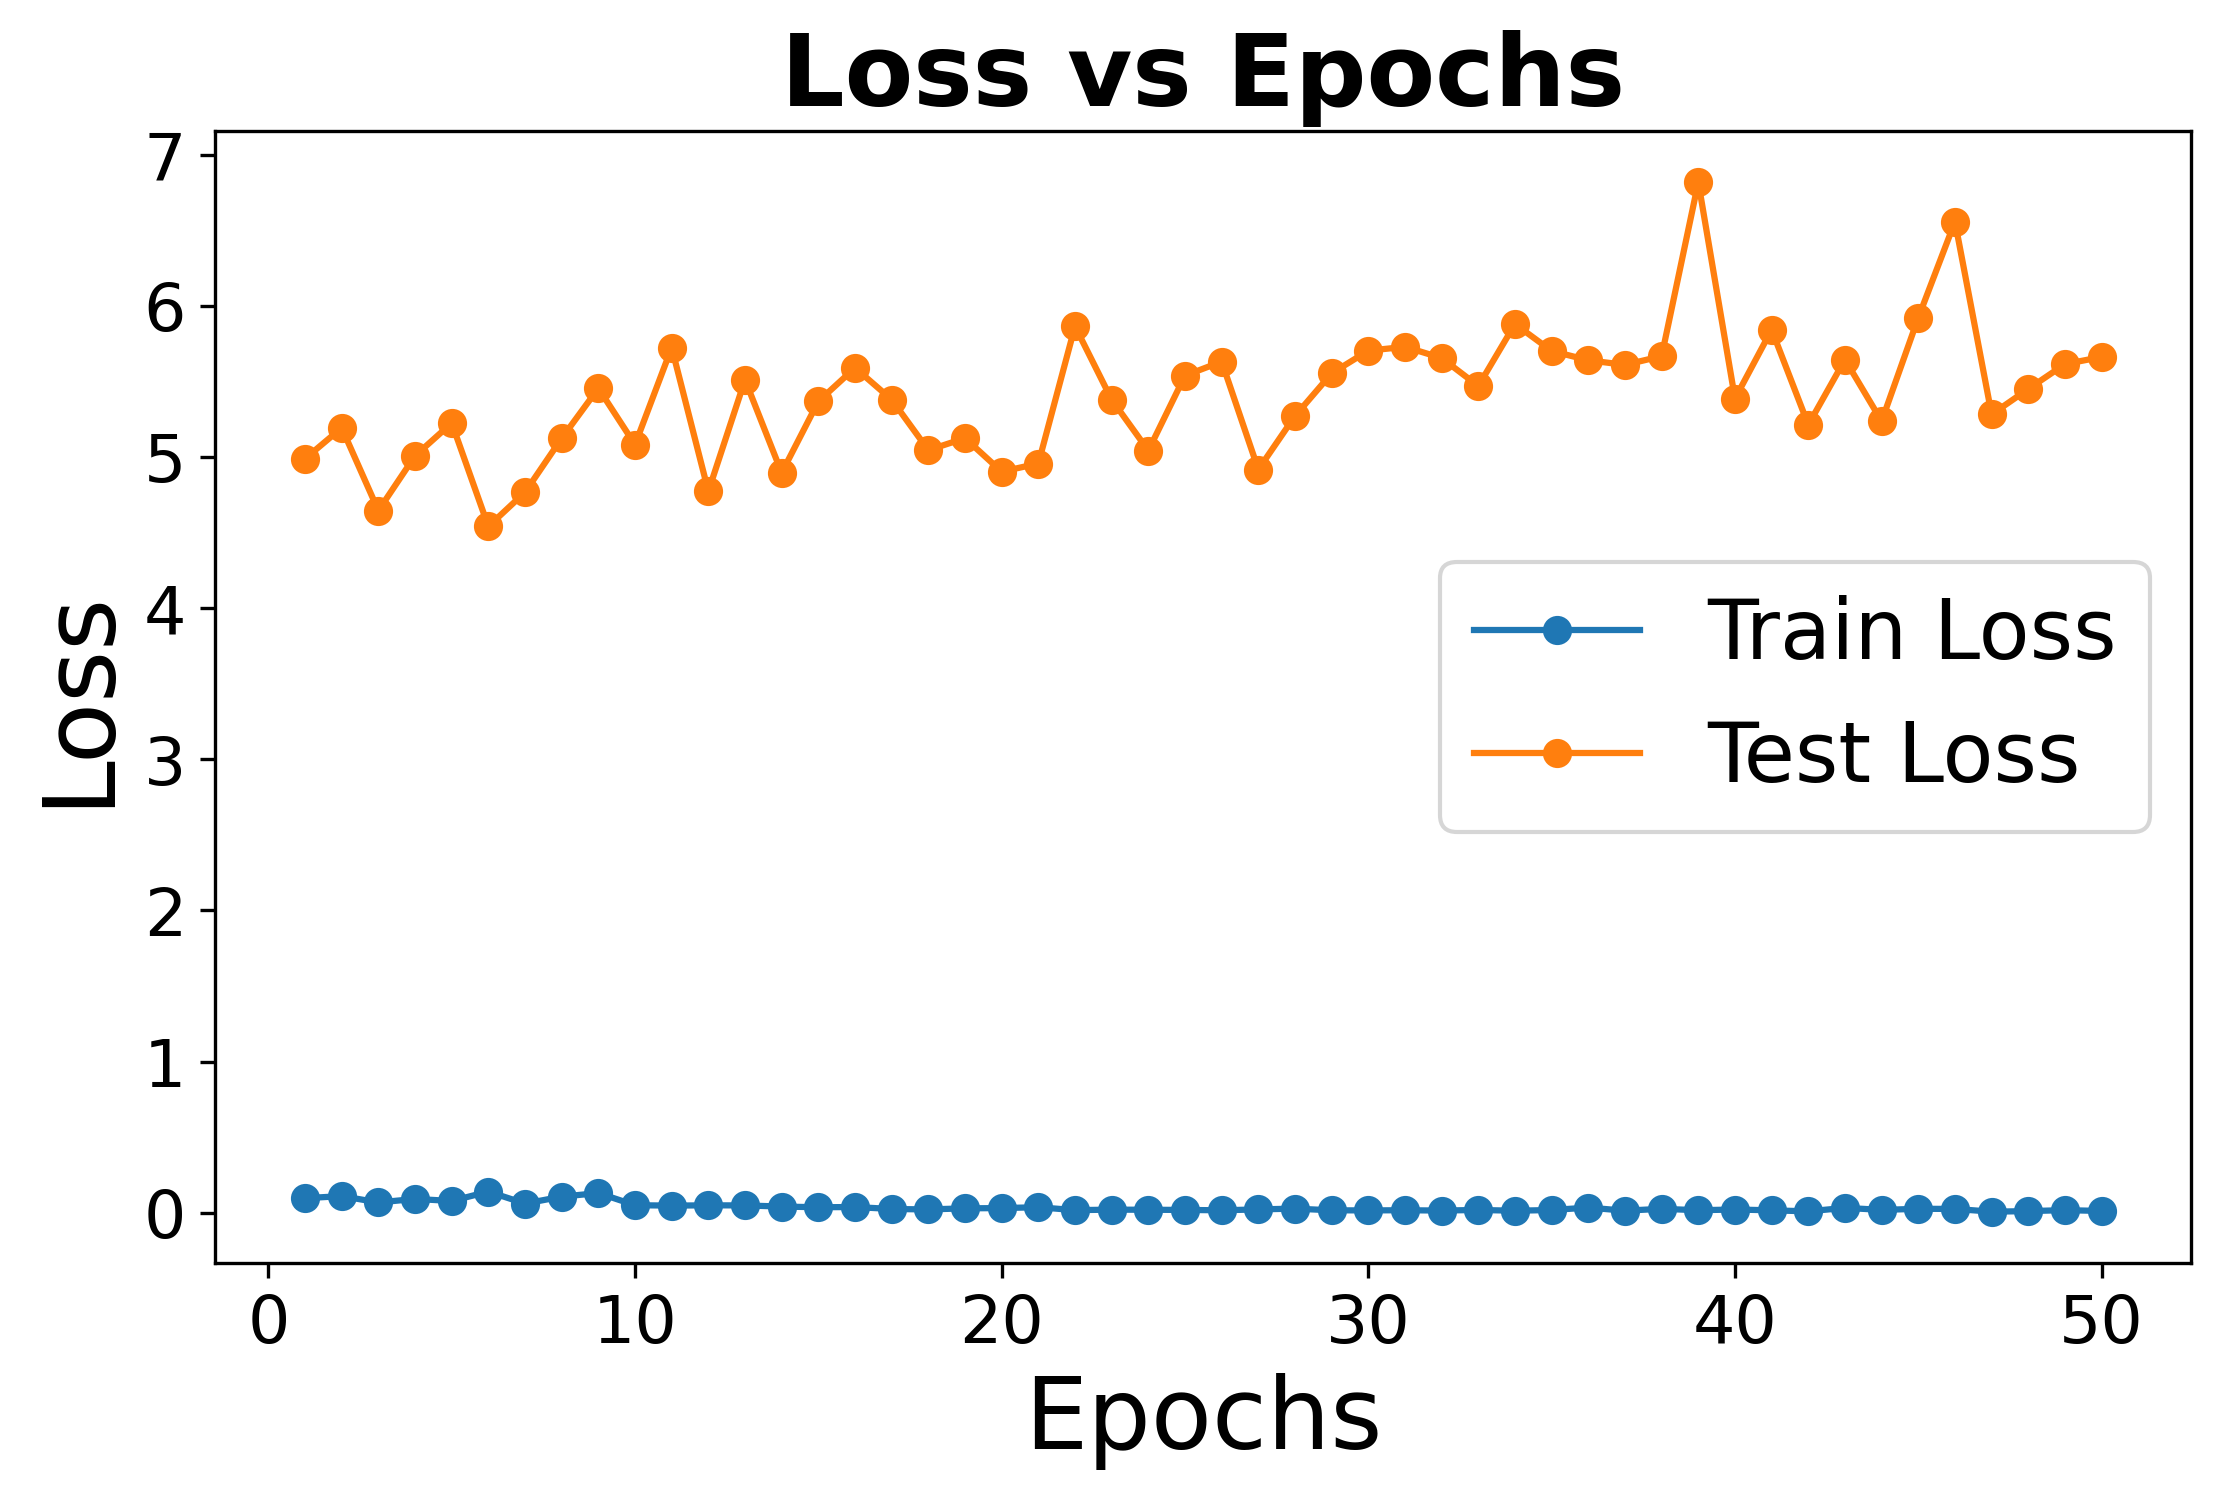

In [101]:
# from lab 8
import seaborn as sns

from matplotlib import RcParams


myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)


fig, ax = plt.subplots(figsize =(8.5,5), dpi=300)

x = np.arange(1,len(train_loss)+1)

ax.plot(x, train_loss, '-o', label = "Train Loss", linewidth = 1.5)
ax.plot(x, test_loss, '-o', label = "Test Loss", linewidth = 1.5)

ax.set_xlabel("Epochs", fontsize = 24)
ax.set_ylabel("Loss", fontsize = 24)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
ax.set_title("Loss vs Epochs", fontsize = 24, fontweight = 'bold')

plt.savefig("Loss vs Epochs_ResNet18.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("Loss vs Epochs_ResNet18.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()

In [102]:
x_list = x.tolist()

df = pd.DataFrame(list(zip(x_list, train_loss, test_loss)), columns =['Epoch', 'Train_Loss', "Test_Loss"])

df.to_csv('ResNet18_Loss.csv')

## Accuracy Metrics:
The code below is dervied from Pytorch github [code](https://github.com/pytorch/examples/blob/master/imagenet/main.py)

In [103]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [104]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [105]:
def calc_accuracy(model, dataloader):
    model.eval()
    #model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cpu().float(), labels.cpu().long()
        # obtain the outputs from the model
        outputs = model.forward(inputs)
        prec1, prec5 = accuracy(outputs, labels, topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1.avg.cpu().detach().numpy(), top5.avg.cpu().detach().numpy()

In [106]:
top1_accuracy, top5_accuracy = calc_accuracy(ResNet_18, test_loader)
print('top1 accuracy{: .2f}%, top5 accuracy{: .2f}%\n'.format(top1_accuracy, top5_accuracy))

top1 accuracy 4.55%, top5 accuracy 18.18%



In [107]:
# calculating confusion matrix
idx_to_class = inv_map = {v: k for k, v in test.class_to_idx.items()}

correct = []
pred = []

ResNet_18.eval()

with torch.no_grad():
    for batch_idx, (data,target) in enumerate(test_loader):
        if cuda:
          data, target = data.cuda(), target.cuda()
        
        out = ResNet_18(data)


        for _,i in enumerate(out):

            pred.append(torch.argmax(i).cpu().item())
            correct.append(target[_].cpu().item())

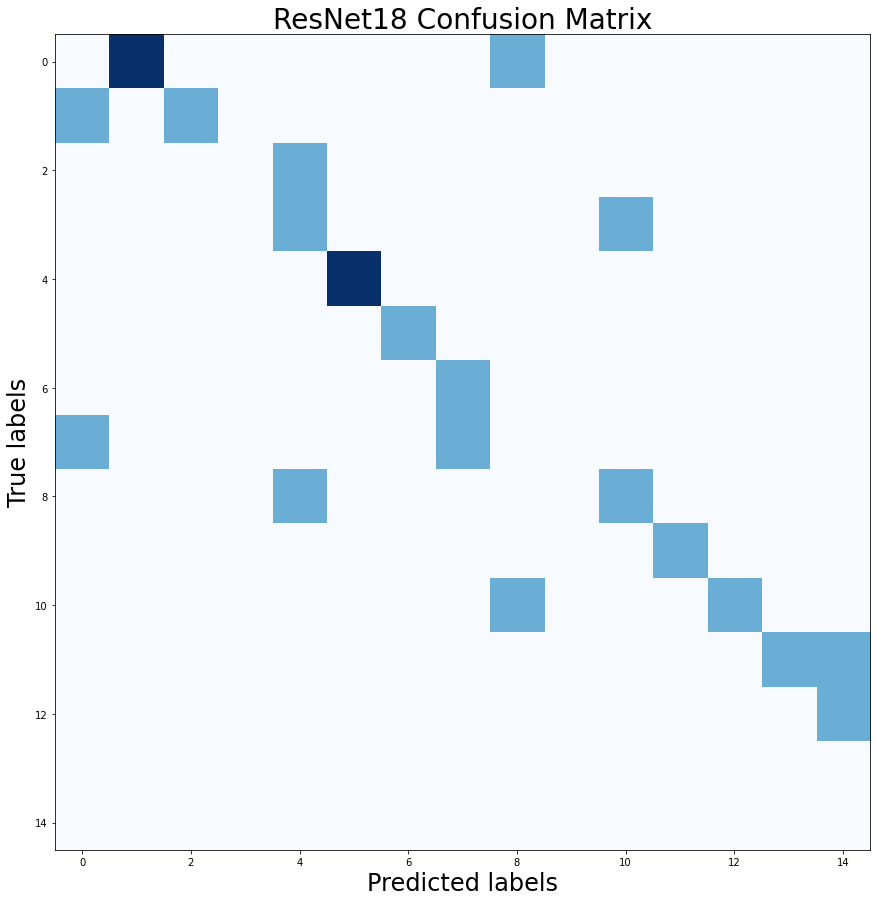

In [108]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_pred= pred, y_true = correct)

fig,ax = plt.subplots(figsize = (15,15))
plt.title('ResNet18 Confusion Matrix', fontsize = 28)
ax.set_xlabel('Predicted labels', fontsize = 24)
ax.set_ylabel('True labels', fontsize = 24)
plt.imshow(conf, interpolation='none', cmap = 'Blues')

fig.savefig("ResNet18_CM.png")

In [109]:
fig.savefig("ResNet18_CM.jpg")